In [165]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import *
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import os

# Modeling Home Prices
This notebooks examines time sereies models (mainly VECM and VAR) for use in predicting quarterly house prices
Here we will read the data in and perform stationarity tests. But first we will look at some of the sample data
for the first MSA

In [175]:
df = pd.read_csv('../MSA_Data/41860.csv',index_col=0)
# df = pd.read_csv('../MSA_Data/10740.csv',index_col=0)
df.index = pd.to_datetime(df.index)
df.index.inferred_type == "datetime64"

True

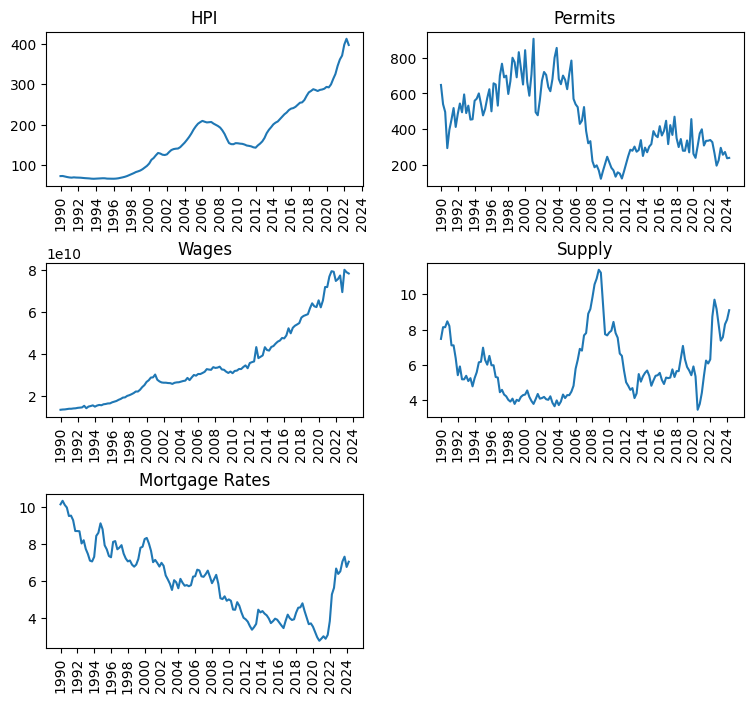

In [176]:
myFmt = mdates.DateFormatter('%Y')
fig, ((ax1, ax2), (ax3, ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(9,8))
ax1.plot(df.index,df['hpi'])
ax1.set_xticks(df.index[::8])
ax1.set_xticklabels(df.index[::8], rotation=90)
ax1.xaxis.set_major_formatter(myFmt)
ax1.set_title("HPI")

ax2.plot(df.index,df['perm'])
ax2.set_xticks(df.index[::8])
ax2.set_xticklabels(df.index[::8], rotation=90)
ax2.xaxis.set_major_formatter(myFmt)
ax2.set_title("Permits")

ax3.plot(df.index,df['wage'])
ax3.set_xticks(df.index[::8])
ax3.set_xticklabels(df.index[::8], rotation=90)
ax3.xaxis.set_major_formatter(myFmt)
ax3.set_title("Wages")

ax4.plot(df.index,df['supply'])
ax4.set_xticks(df.index[::8])
ax4.set_xticklabels(df.index[::8], rotation=90)
ax4.xaxis.set_major_formatter(myFmt)
ax4.set_title("Supply")

ax5.plot(df.index,df['mr'])
ax5.set_xticks(df.index[::8])
ax5.set_xticklabels(df.index[::8], rotation=90)
ax5.xaxis.set_major_formatter(myFmt)
ax5.set_title("Mortgage Rates")

ax6.set_visible(False)

fig.subplots_adjust(hspace=.5)

In [177]:
# Create adf test to work with stationary data testing first data set
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='BIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        print("\n")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        print("\n")

In [178]:
print('HPI')
adf_test(df['hpi'])
adf_test(df['hpi'].diff())

print('Permits')
adf_test(df['perm'])
adf_test(df['perm'].diff())

print('Wages')
adf_test(df['wage'])
adf_test(df['wage'].diff())

print('Supply')
adf_test(df['supply'])
adf_test(df['supply'].diff())

print('Mortgage Rates')
adf_test(df['mr'])
adf_test(df['mr'].diff())

HPI
Augmented Dickey-Fuller Test: 
ADF test statistic        0.627699
p-value                   0.988279
# lags used               4.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


Augmented Dickey-Fuller Test: 
ADF test statistic       -4.458181
p-value                   0.000234
# lags used               3.000000
# observations          126.000000
critical value (1%)      -3.483346
critical value (5%)      -2.884766
critical value (10%)     -2.579156
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Permits
Augmented Dickey-Fuller Test: 
ADF test statistic       -1.332941
p-value                   0.613971
# lags used               2.000000
# observations          135.000000
critical value (1%)      -3.47

# Model Type and Selection
After seeing some of our data is I(1) when examining ADF tests we opt to look at both VECM  
in differences

In [179]:
df_lev = df
# df = df.diff()
df = df.dropna()
print(df)



lag_order = select_order(data=df, maxlags=10, seasons=4)
lag_order.summary()

                   hpi        perm          wage    supply         mr
1990-03-31   73.190000  647.423859  1.342820e+10  7.466667  10.131538
1990-06-30   73.390000  540.514182  1.355265e+10  8.133333  10.323846
1990-09-30   72.006667  497.092644  1.359794e+10  8.133333  10.103077
1990-12-31   70.826667  296.042653  1.373204e+10  8.466667   9.959231
1991-03-31   69.843333  397.554167  1.391300e+10  8.200000   9.500769
...                ...         ...           ...       ...        ...
2021-09-30  361.003333  336.647374  7.928965e+10  6.233333   2.872143
2021-12-31  370.760000  337.111749  7.903033e+10  6.066667   3.079231
2022-03-31  397.750000  341.306573  7.465703e+10  6.300000   3.822308
2022-06-30  412.170000  329.249879  7.555466e+10  8.733333   5.266154
2022-09-30  396.870000  268.392517  7.725265e+10  9.700000   5.623077

[131 rows x 5 columns]


C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

,AIC,BIC,FPE,HQIC
0,50.29,51.33*,6.922e+21,50.71
1,50.01,51.63,5.242e+21,50.67*
2,49.94,52.15,4.952e+21,50.84
3,49.89,52.68,4.782e+21,51.02
4,49.68*,53.05,3.942e+21*,51.05
5,49.78,53.73,4.496e+21,51.38
6,49.96,54.49,5.639e+21,51.80
7,49.79,54.90,5.002e+21,51.86
8,49.90,55.59,6.019e+21,52.21
9,49.98,56.25,7.162e+21,52.52


In [180]:
print(lag_order)
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 0, FPE -> 4, HQIC ->  1>


(4, 0, 4, 1)

In [181]:
rank_test = select_coint_rank(df, 1, 4, method="trace", signif=0.05)

print(rank_test.rank)

1


In [182]:
model = VECM(df, deterministic="ci", seasons=4,
             k_ar_diff=lag_order.aic,  # =3
             coint_rank=rank_test.rank)

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


In [183]:
vecm_res = model.fit()
vecm_res.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
season1,-0.0878,0.637,-0.138,0.890,-1.337,1.161
season2,-0.6632,0.629,-1.055,0.292,-1.896,0.569
season3,-0.9084,0.631,-1.439,0.150,-2.146,0.329
L1.hpi,0.7191,0.089,8.111,0.000,0.545,0.893
L1.perm,0.0071,0.003,2.191,0.028,0.001,0.013
L1.wage,-5.198e-11,1.66e-10,-0.313,0.754,-3.77e-10,2.73e-10
L1.supply,-1.3358,0.536,-2.493,0.013,-2.386,-0.285
L1.mr,0.1659,0.758,0.219,0.827,-1.320,1.651
L2.hpi,-0.3968,0.104,-3.831,0.000,-0.600,-0.194
L2.perm,-0.0013,0.004,-0.354,0.723,-0.008,0.006


In [184]:
print(vecm_res.alpha)
print(vecm_res.stderr_alpha)


[[ 1.34919356e-02]
 [ 1.07416838e-01]
 [ 6.53413717e+06]
 [-2.56197572e-04]
 [-6.28475153e-04]]
[[2.77999306e-03]
 [8.05881566e-02]
 [1.50115235e+06]
 [5.34707886e-04]
 [3.34820010e-04]]


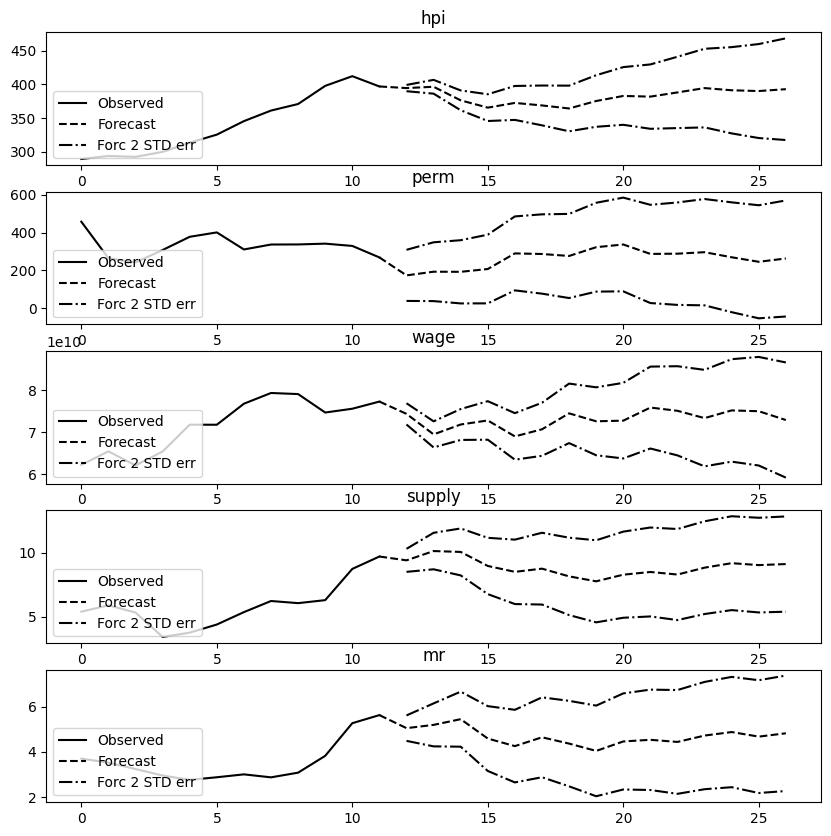

In [185]:
vecm_res.plot_forecast(steps=15, n_last_obs=12)


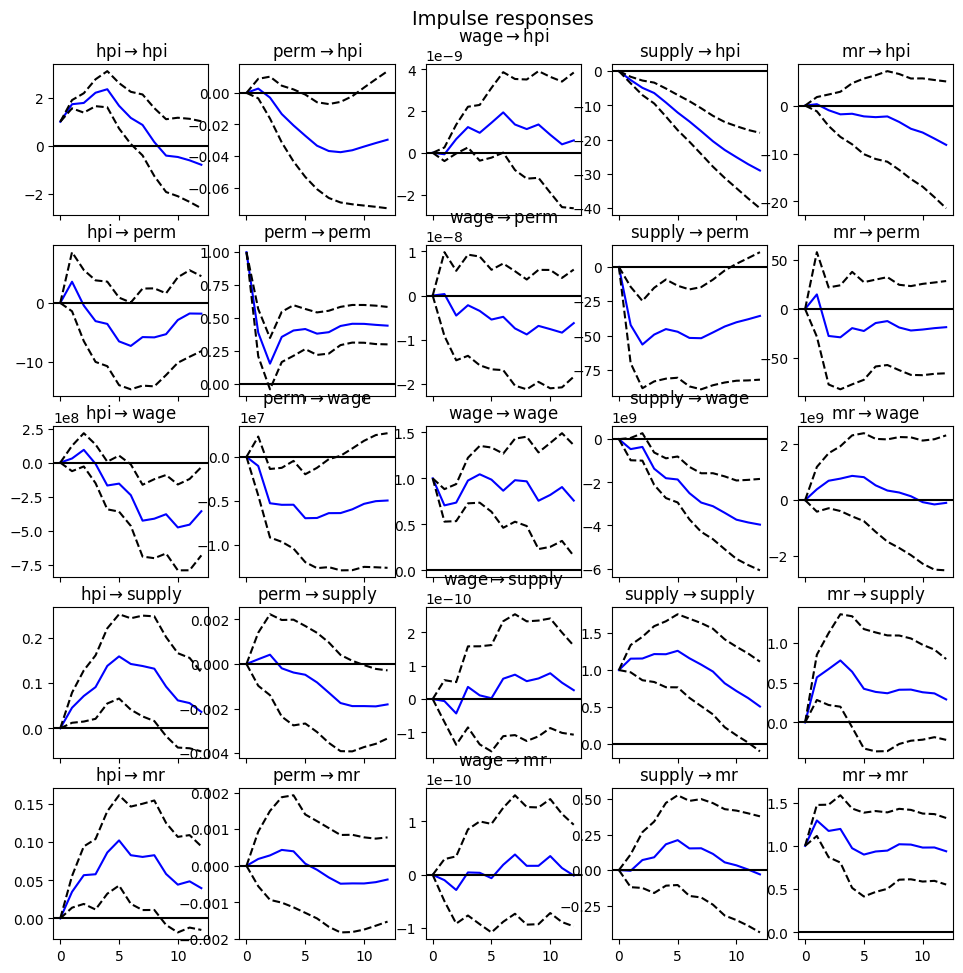

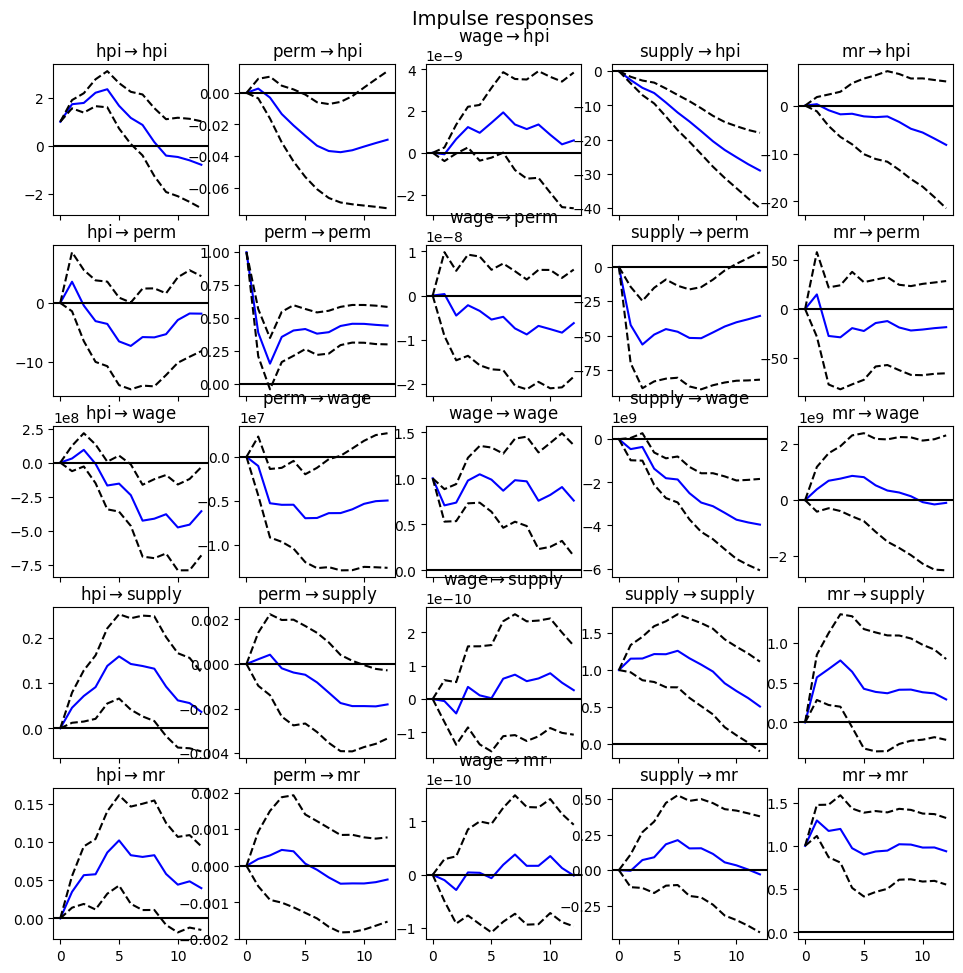

In [186]:
num_periods = 12
ir = vecm_res.irf(periods=num_periods)
ir.plot()


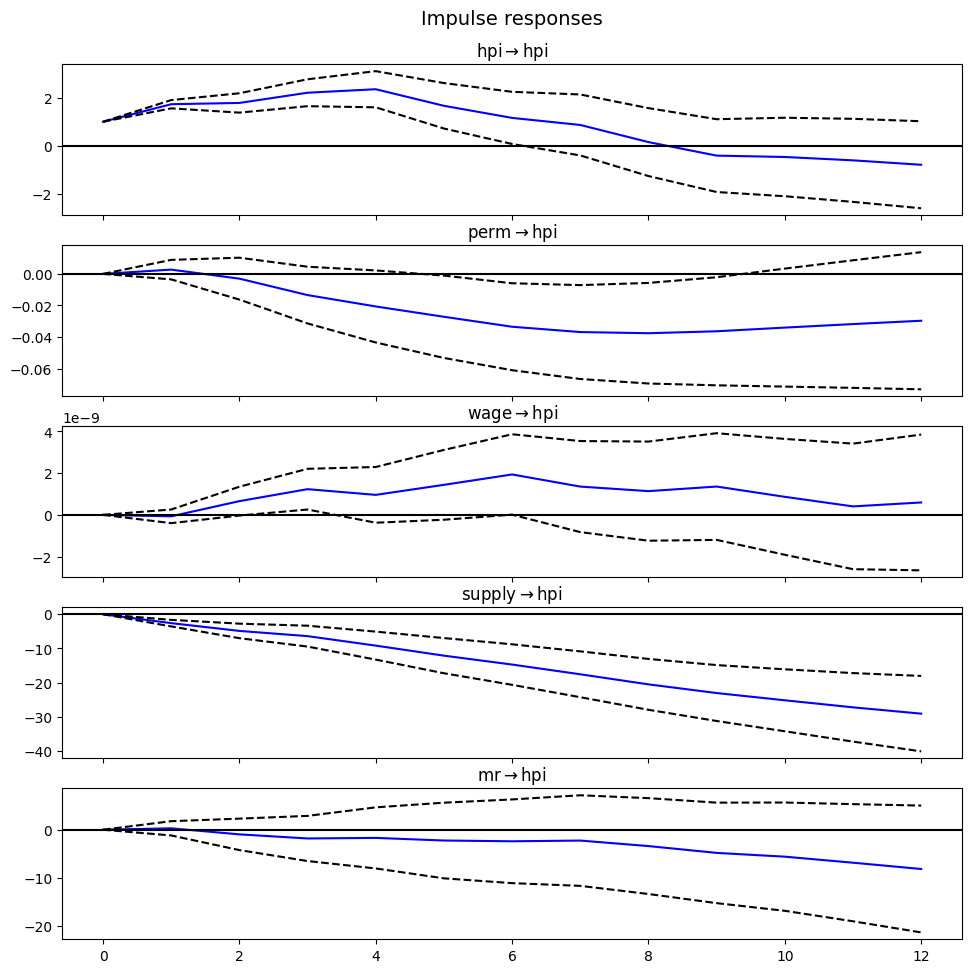

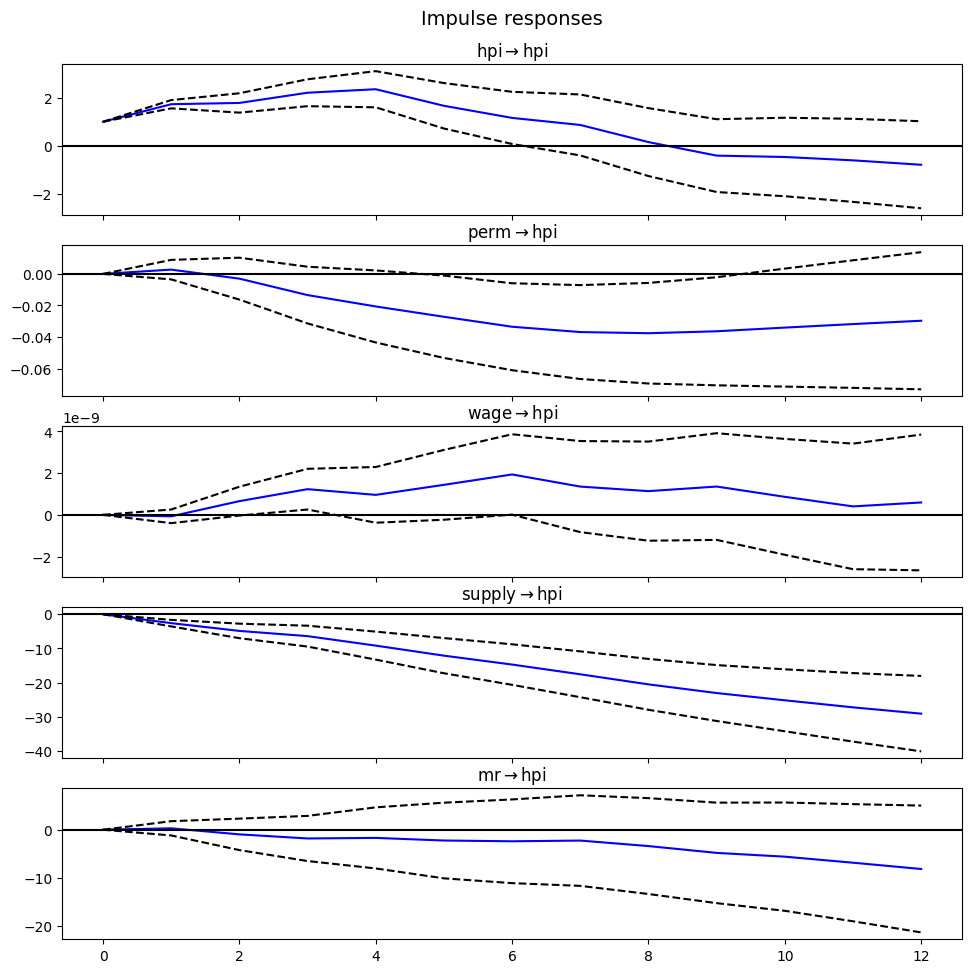

In [187]:
ir.plot(response='hpi')

In [188]:
three_year_forecast = vecm_res.predict(12)
# print(np.transpose(three_year_forecast[:,0]))
temp = np.transpose(three_year_forecast[:,0])
temp = np.transpose(temp)
df_index = pd.date_range(start='12/31/2022', periods = 12, freq='Q') 

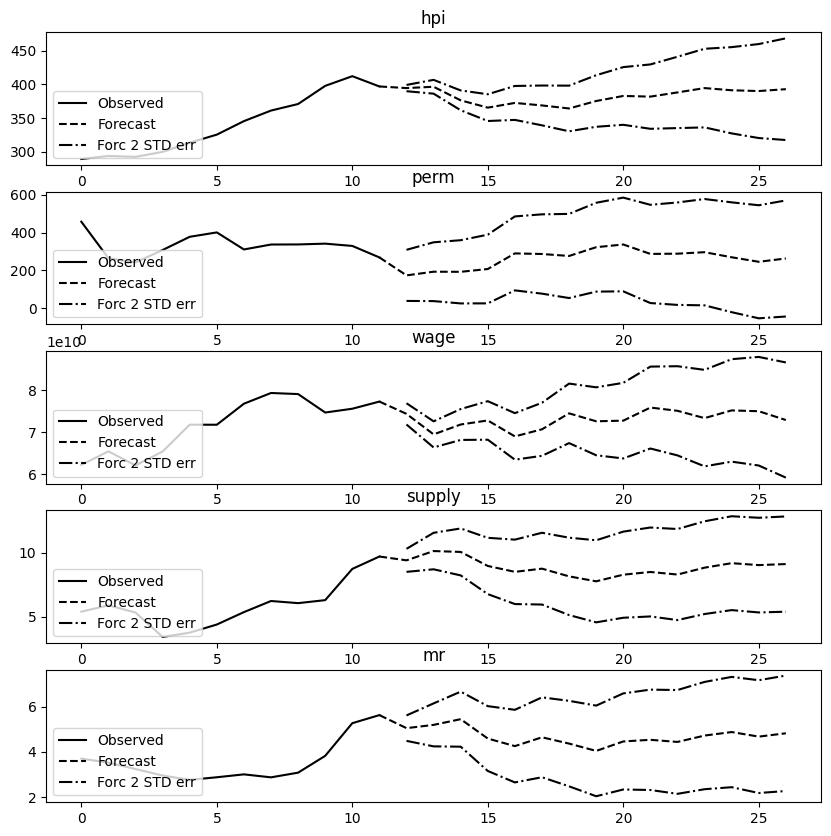

In [189]:
# ir.plot(response='hpi').savefig('test.png')
vecm_res.plot_forecast(steps=15, n_last_obs=12)


  # The Rest of the CBSA
  
  This example was for San Francisco we repeat this modeling and forecasting for each of the 112 MSAs
  for which we have data and construct a forecast that we output.
  

In [205]:
directory = '../MSA_Data/'
df_index = pd.date_range(start='12/31/2022', periods = 12, freq='Q') 

# iterate over files in
# that directory
i=0
for filename in os.listdir(directory):
    i=i+1
    f = os.path.join(directory, filename)
    # checking if it is a file
    #print(filename[:5])
    df_temp = pd.read_csv(os.path.join(directory, filename),index_col = 0)
    df_temp.index = pd.to_datetime(df_temp.index)
    df_temp.index.inferred_type == "datetime64"
    df_temp = df_temp.dropna()
    

    lag_order = select_order(data=df_temp, maxlags=10, seasons=4)
    lag_order.summary()
    rank_test = select_coint_rank(df_temp, 1, 4, method="trace", signif=0.05)
    model = VECM(df_temp, deterministic="ci", seasons=4,
             k_ar_diff=lag_order.aic,  # =3
             coint_rank=max(rank_test.rank,1))
    vecm_res = model.fit()
    ir = vecm_res.irf(periods=12)
    three_year_forecast = vecm_res.predict(12)
    # ir.plot(response='hpi').savefig('../Output/Figures/IRF/'+filename[:5]+'.png')
    # fig_forecast = vecm_res.plot_forecast(steps=15, n_last_obs=12)
    # fig_forecast.savefig('../Output/Figures/Forecast/'+filename[:5]+'.png')
    if i == 1: 
        temp = np.transpose(three_year_forecast[:,0])
        temp = np.transpose(temp) 
        df_fcast = pd.DataFrame(data = temp, index = df_index, columns =[filename[:5]])
    
    if i > 1:
        temp = np.transpose(three_year_forecast[:,0])
        temp = np.transpose(temp) 
        df_new_fcast = pd.DataFrame(data = temp, index = df_index, columns =[filename[:5]])
        df_fcast = pd.concat([df_fcast, df_new_fcast], axis=1)
        
    
    
    
    
    
    
    
    
    

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\tubbs\AppData\Local\Programs\Python

In [206]:
df_fcast

,10740,10900,11260,12060,12100,12220,12420,12580,13460,13820,...,45220,45300,45500,45940,46060,46140,47220,47260,47900,48900
2022-12-31,255.704831,258.699933,238.722470,257.367136,282.882500,236.654033,486.239379,272.117521,395.999044,251.624648,...,261.479016,369.837633,254.237578,262.997776,285.100797,217.989169,251.918292,289.108303,305.098169,282.284669
2023-03-31,256.266173,261.546489,237.536808,261.055555,281.972602,237.823076,491.725904,275.720888,380.863100,257.815468,...,264.206076,381.620661,271.443544,267.130674,286.214009,218.627633,255.999224,288.586871,302.830463,292.728101
2023-06-30,257.920402,263.888107,235.923582,261.536460,280.117550,233.624210,499.691477,280.271722,361.946565,260.949012,...,266.450288,380.412963,288.016811,270.610493,286.269940,215.234803,258.553701,287.699233,299.345860,302.523732
2023-09-30,258.606265,265.480326,235.182310,263.650074,277.743070,233.432980,498.996305,283.544955,350.686867,264.935958,...,268.297591,370.522510,309.074121,274.216537,283.719037,209.352088,260.485223,286.151183,295.496360,311.241275
2023-12-31,260.031651,266.758334,235.009341,265.446407,275.473547,229.864415,494.218559,283.662928,316.286371,270.451667,...,269.877844,361.412633,335.598889,278.401104,280.413440,199.176256,263.137341,284.589553,292.493069,319.182616
2024-03-31,261.467522,267.914459,235.213640,267.660210,273.174432,228.382432,492.632044,285.338329,301.755860,273.519635,...,271.458014,339.844552,365.193411,283.175831,278.608534,181.349041,266.104912,283.396547,289.921226,326.173675
2024-06-30,263.294641,268.800499,236.092925,272.706637,270.904006,218.459882,499.725464,286.217637,271.172638,276.551279,...,272.731077,311.842810,394.900991,288.305024,277.588812,162.881077,269.087675,282.349689,287.787800,332.683299
2024-09-30,265.056362,269.264385,236.830696,277.167947,268.364275,217.157317,510.056733,287.280383,261.981554,281.283539,...,273.751130,299.171307,435.246231,293.556472,276.360875,139.303217,271.747417,281.669809,285.913928,338.307613
2024-12-31,267.172245,269.719706,237.595114,283.898611,266.074924,215.881392,519.021580,289.499784,268.901068,284.164948,...,274.606103,286.484314,480.043042,299.287406,276.021559,113.035523,274.592097,281.469446,284.695521,343.346327
2025-03-31,269.538399,270.220443,238.215143,292.131961,263.799109,213.423065,531.110307,289.650904,298.337900,287.084403,...,275.557034,262.542552,527.892289,305.296618,277.210037,87.222613,277.723559,281.749039,284.128995,347.632506


In [204]:
df_fcast.to_csv('../Output/CBSA_Forecasts.csv')